In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import re
import json
import random
import pandas as pd

from glob import iglob
from PIL import Image
from ast import literal_eval
from os.path import join as pjoin

In [ ]:
ROOT_DIR = "/home/kimsubin/mm_counselor/mirror"
ANNOT_DIR = pjoin(ROOT_DIR, "annot_data")
IMAGE_DIR = pjoin(ROOT_DIR, "utterfeat_336x336")

POSTPROC_PROMPT_DIR = pjoin(ANNOT_DIR, "utterfeat/postprocess", "prompts")
POSTPROC_RESULT_DIR = pjoin(ANNOT_DIR, "utterfeat/postprocess", "results")


In [3]:
def split_list_into_chunks(lst, chunk_size=2):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

def write_jsonl(save_path, json_obj):
    with open(save_path, 'w', encoding='utf-8') as f:
        for entry in json_obj:
            json.dump(entry, f, ensure_ascii=False)
            f.write('\n')
    return

def write_line(path, entry):
    with open(path, 'a+') as f:
        json.dump(entry, f, ensure_ascii=False)
        f.write('\n')

In [4]:
mirror = pd.read_csv(pjoin(ANNOT_DIR, "mirror.csv"), converters={
    'proc_dialogue': literal_eval
})

---

### **Attribute Detectability Filtering**

**Preprocessing: Split into Chunks**

In [64]:
image_path_list = list(iglob(pjoin(IMAGE_DIR, "*/*.*")))
image_path_chunks = split_list_into_chunks(image_path_list, chunk_size=len(image_path_list) // 4)

In [ ]:
for i, chunk in enumerate(image_path_chunks):
    write_jsonl(save_path=pjoin(POSTPROC_PROMPT_DIR, f"image_paths_{i}.jsonl"), 
                json_obj=chunk)

**Check Drop Indices**

In [ ]:
drop_paths = list(iglob(pjoin(POSTPROC_RESULT_DIR, "attribute", "drop_*.jsonl")))
drop_list = []
for path in drop_paths:
    drop_list += [json.loads(q) for q in open(path, 'r')]

In [53]:
write_jsonl(json_obj=drop_list, save_path=pjoin(POSTPROC_RESULT_DIR, "attribute", "drop.jsonl"))

In [ ]:
sample_entry = random.choice(drop_list)
sample_entry

{'img_path': '/home/kimsubin/mm_counselor/mirror/utterfeat_336x336/cactus-4291-behavioral-resistance/turn:7_167941.png',
 'error': 'Face could not be detected in /home/kimsubin/mm_counselor/mirror/utterfeat_336x336/cactus-4291-behavioral-resistance/turn:7_167941.png.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.'}

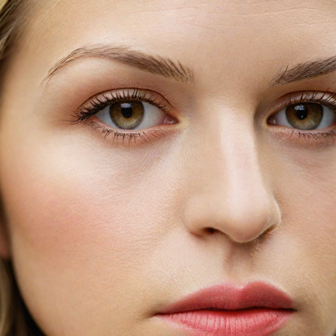

In [ ]:
Image.open(sample_entry['img_path'])

In [ ]:
drop_ids = list(set(map(lambda x: x['img_path'].split("/")[-2], drop_list)))
for idx in drop_ids:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), 
               entry={'type': 'no face', 'idx': idx})

**Mismatch Gender**

In [ ]:
attr_paths = list(iglob(pjoin(POSTPROC_RESULT_DIR, "attribute", "facial_info_*.jsonl")))
attr_results = []
for path in attr_paths:
    attr_results += [json.loads(q) for q in open(path, 'r')]

In [42]:
attr_df = pd.DataFrame(attr_results)

In [43]:
attr_df_w_mirror = mirror[['idx', 'img_path', 'identity', 'age', 'dominant_gender']].merge(attr_df, left_on="idx", right_on='dialog_id')

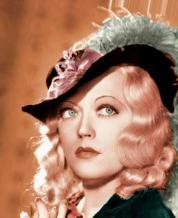

In [ ]:
sample = attr_df_w_mirror[attr_df_w_mirror['dominant_gender_x'] != attr_df_w_mirror['dominant_gender_y']].iloc[10]
Image.open(sample['img_path_x'])

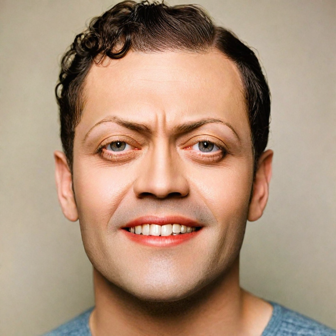

In [63]:
Image.open(sample['img_path_y'])

In [ ]:
drop_dialogue_idx = list(set(attr_df_w_mirror[attr_df_w_mirror['dominant_gender_x'] != attr_df_w_mirror['dominant_gender_y']]['idx']))

for idx in drop_dialogue_idx:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), 
               entry={'type': 'different gender', 'idx': idx})

In [ ]:
attr_df_w_mirror['age_diff'] = attr_df_w_mirror['age_x'] - attr_df_w_mirror['age_y']
attr_df_w_mirror['age_diff'] = attr_df_w_mirror['age_diff'].apply(lambda x: abs(x))

attr_df_w_mirror[['age_diff']].describe()

,age_diff
count,390491.000000
mean,6.334784
std,5.946437
min,0.000000
25%,2.000000
50%,5.000000
75%,9.000000
max,41.000000


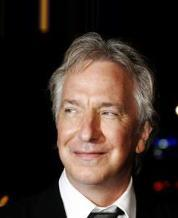

In [ ]:
sample = attr_df_w_mirror[attr_df_w_mirror['age_diff'] > 10].iloc[55]
Image.open(sample['img_path_x'])

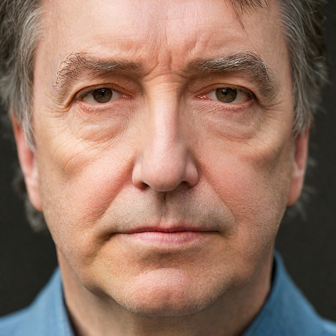

In [61]:
Image.open(sample['img_path_y'])

In [ ]:
drop_dialogue_idx = list(set(attr_df_w_mirror[attr_df_w_mirror['age_diff'] > 10]['idx']))
for idx in drop_dialogue_idx:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), entry={'type': 'different age group',
                                                                     'idx': idx})

**Identity Preservation Filtering**

In [ ]:
results_paths = list(iglob(pjoin(POSTPROC_RESULT_DIR, "identity", "results_*.jsonl")))
results = [json.loads(q) for path in results_paths for q in open(path, 'r')]
len(results)

383342

In [ ]:
drop_paths = list(iglob(pjoin(POSTPROC_RESULT_DIR, "identity", "drop_*.jsonl")))
drop_results = [json.loads(q) for path in drop_paths for q in open(path, 'r')]

drop_dialogue_idx = list(set(map(lambda x: x['idx'], drop_results)))

In [ ]:
low_sims = list(filter(lambda x: float(x['cosine_similarity']) < 0.2, results))
low_sims_dialogue_idx = list(set(map(lambda x: x['idx'], low_sims)))

In [ ]:
for x in low_sims_dialogue_idx:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), 
               entry={"type": "low similarity", "idx": x})

for x in drop_dialogue_idx:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), 
               entry={"type": "deepface face not detected", "idx": x})

---

### **CLIP-based Image-Text Consistency**

In [ ]:
import os
from os.path import join as pjoin

In [86]:
drop_results = [json.loads(q) for q in open(pjoin(POSTPROC_RESULT_DIR, "clip", "low_clip_sim.jsonl"), 'r')]
len(drop_results)

1301

In [88]:
drop_dialogue_idx = set(map(lambda x: x['img_path'].split("/")[-2], drop_results))
len(drop_dialogue_idx)

1217

In [ ]:
for idx in drop_dialogue_idx:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), 
               entry={'type': 'low clip similarity', 'idx': idx})

---

#### **NSFW Filtering**

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from PIL import Image
from os.path import join as pjoin
from transformers import pipeline

/home/kimsubin/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-19 14:43:45.899103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732027425.981028  817726 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732027426.006928  817726 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:43:46.211348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical op

In [ ]:
img = Image.open(IMAGE_DIR, "cactus-760-emotional-resistance/turn:21_007353.png")
classifier = pipeline("image-classification", model="Falconsai/nsfw_image_detection")
classifier(img)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'normal', 'score': 0.988319993019104},
 {'label': 'nsfw', 'score': 0.01070130243897438}]

In [90]:
drop_results = [json.loads(q) for q in open(pjoin(POSTPROC_RESULT_DIR, "nsfw", "drop.jsonl"), 'r')]
len(drop_results)

5996

In [91]:
drop_dialogue_idx = set(map(lambda x: x['dialog_id'], drop_results))
len(drop_dialogue_idx)

3218

In [ ]:
for idx in drop_dialogue_idx:
    write_line(path=pjoin(POSTPROC_RESULT_DIR, "drop_idx.jsonl"), 
               entry={'type': 'nsfw image', 'idx': idx})

---